# Example of using SIFT to find points of interest

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# First, let's do a 

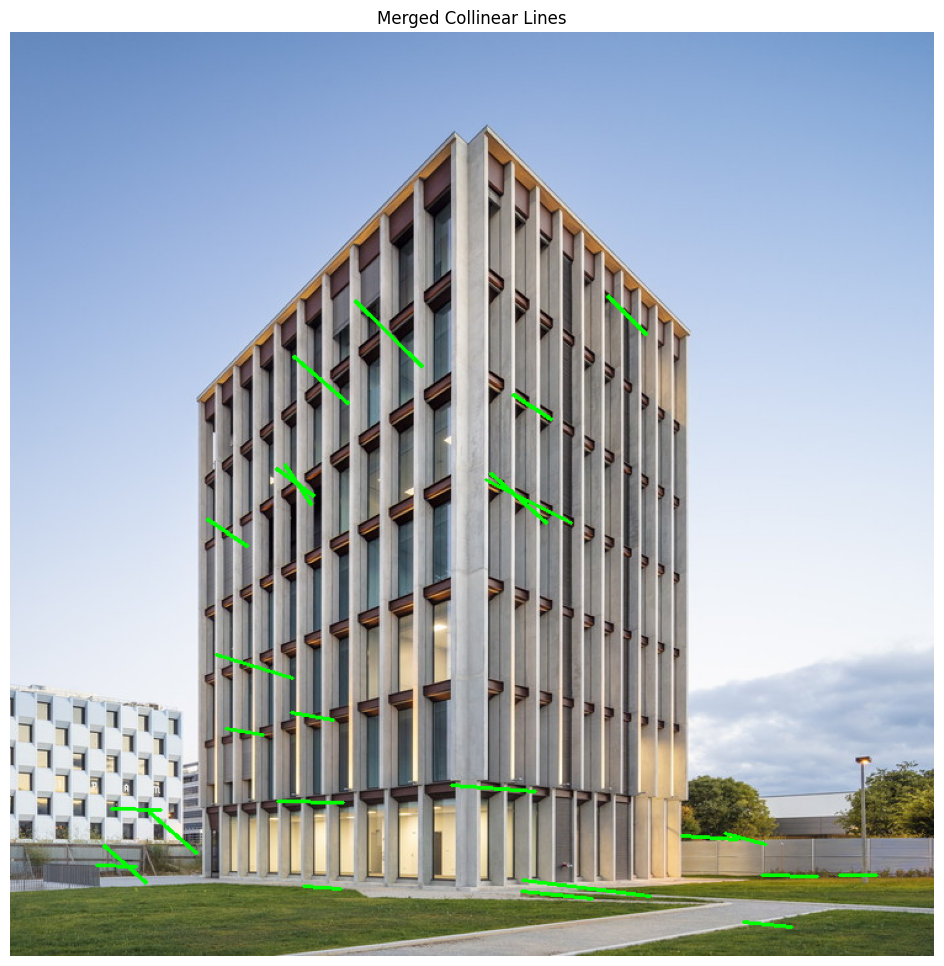

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def angle_between_lines(line1, line2):
    """Calculate the angle difference between two lines."""
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    angle1 = np.arctan2(y2 - y1, x2 - x1)
    angle2 = np.arctan2(y4 - y3, x4 - x3)
    return np.abs(angle1 - angle2) * 180 / np.pi  # Convert to degrees

def merge_lines(lines, angle_threshold=10, distance_threshold=30):
    """Merge nearly collinear and close lines into longer segments."""
    merged_lines = []
    used = set()

    for i, line1 in enumerate(lines):
        if i in used:
            continue

        x1, y1, x2, y2 = line1
        group = [(x1, y1, x2, y2)]
        used.add(i)

        for j, line2 in enumerate(lines):
            if j in used:
                continue

            x3, y3, x4, y4 = line2
            angle_diff = angle_between_lines(line1, line2)

            # Check if lines are nearly parallel and close to each other
            if angle_diff < angle_threshold:
                dist1 = np.hypot(x1 - x3, y1 - y3)
                dist2 = np.hypot(x2 - x4, y2 - y4)
                if dist1 < distance_threshold or dist2 < distance_threshold:
                    group.append((x3, y3, x4, y4))
                    used.add(j)

        # Merge grouped lines into a single extended line
        x_coords = [pt for line in group for pt in (line[0], line[2])]
        y_coords = [pt for line in group for pt in (line[1], line[3])]
        merged_lines.append((min(x_coords), min(y_coords), max(x_coords), max(y_coords)))

    return merged_lines

# Load the image
path = "./images/building1.png"
image = cv2.imread(path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Convert keypoints to numpy array of coordinates
keypoints_coords = np.array([kp.pt for kp in keypoints], dtype=np.float32)

# Create an empty mask to mark keypoints
mask = np.zeros_like(gray)
for x, y in keypoints_coords:
    mask[int(y), int(x)] = 255  # Mark keypoints as white dots

# Apply edge detection
edges = cv2.Canny(mask, 50, 150)

# Detect lines using Hough Transform
raw_lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=30, minLineLength=30, maxLineGap=10)
lines = [tuple(line[0]) for line in raw_lines] if raw_lines is not None else []

# Merge nearly collinear lines
merged_lines = merge_lines(lines)

# Draw merged lines
image_with_lines = image.copy()
for x1, y1, x2, y2 in merged_lines:
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines

# Convert to RGB for displaying with matplotlib
image_final_rgb = cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(12, 12))
plt.imshow(image_final_rgb)
plt.axis('off')
plt.title("Merged Collinear Lines")
plt.show()
